In [1]:
import os,sys
import json
import torch

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [2]:
# 构建数据集
from torch.utils.data import DataLoader,Subset
from src.dataset import build_global_vocab_and_maxcount, CLEVRMultiLabelByImage
import torchvision.transforms as T


clevr_root = "../CLEVR_v1.0"

# 全局统计：colors/shapes/max_objects（train+val+test）
colors, shapes, max_objects, _ = build_global_vocab_and_maxcount(clevr_root, splits=("train","val"))

print("num_colors:", len(colors), colors)
print("num_shapes:", len(shapes), shapes)
print("max_objects:", max_objects)


train_ds = CLEVRMultiLabelByImage(
    clevr_root=clevr_root,
    split="train",
    colors=colors,
    shapes=shapes,
    max_objects=max_objects,
)

# 取前 N 个样本（最快、可复现）
N = 2000
train_ds_small = Subset(train_ds, list(range(N)))

train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=0)

num_colors: 8 ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow']
num_shapes: 3 ['cube', 'cylinder', 'sphere']
max_objects: 10


In [3]:
# 构建模型
from src.model2 import REVAE_V2

revae = REVAE_V2()

In [4]:
from src.train2 import TrainConfig, fit_v2
import torch.optim as optim

cfg = TrainConfig(
    epochs=10,
    lr=1e-3,
    beta_kl=1,
    recon_loss="bce_logits",   # 你已确认 images 在 [0,1] bce_logits\mse\l1
    use_amp=False,
    save_best=False,
    ckpt_dir="../checkpoints",
    ckpt_name="revae_v2222.pt",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

optimizer = optim.Adam(revae.parameters(), lr=cfg.lr)

# 若你还没做 val_dl，可以先 val_loader=None
result = fit_v2(revae, train_dl, val_loader=None, optimizer=optimizer, cfg = cfg)


[train] epoch 1: total=103025.8124 recon=103007.9417 kl=11.3121 loss=6.5585
[train] epoch 2: total=102374.9491 recon=102334.3664 kl=34.6500 loss=5.9328
[train] epoch 3: total=102078.2245 recon=102018.6392 kl=53.6687 loss=5.9167
[train] epoch 4: total=101927.5825 recon=101864.1151 kl=57.6634 loss=5.8040
[train] epoch 5: total=101835.2140 recon=101769.3041 kl=60.1950 loss=5.7146
[train] epoch 6: total=101792.5984 recon=101724.5912 kl=62.3032 loss=5.7040
[train] epoch 7: total=101753.8172 recon=101683.7080 kl=64.4587 loss=5.6505
[train] epoch 8: total=101693.9266 recon=101621.4864 kl=66.7726 loss=5.6676
[train] epoch 9: total=101656.4261 recon=101582.8059 kl=68.0716 loss=5.5488
[train] epoch 10: total=101631.9964 recon=101557.7294 kl=68.7040 loss=5.5631


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "../checkpoints/revae_v2.pt"  # 你的实际路径
revae = REVAE_V2().to(device)

ckpt = torch.load(ckpt_path, map_location=device)

# 如果你保存的是 {"model": state_dict, ...}
if isinstance(ckpt, dict) and "model" in ckpt:
    revae.load_state_dict(ckpt["model"])
else:
    # 如果你保存的就是纯 state_dict
    revae.load_state_dict(ckpt)

revae.eval()
print("Loaded checkpoint from:", ckpt_path)


C:\Users\cyh\AppData\Local\Temp\ipykernel_18488\534128656.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Loaded checkpoint from: ../checkpoints/revae_v2.pt


In [6]:
# 取第 i 张（你可以换 i）
i = 1100
image, color_mh, shape_mh, count_oh, img_fn = train_ds_small[i]

print("file:", img_fn)
print("gt count:", int(count_oh.argmax()))

file: CLEVR_train_001100.png
gt count: 10


In [7]:
with torch.no_grad():
    x = image.unsqueeze(0).to(device)  # (1,3,224,224)

    x_logits, heads, post = revae(x, drop_path = "latent-only")

    p = torch.sigmoid(x_logits)

    # --- 重建 ---
    recon = torch.sigmoid(x_logits)[0].detach().cpu()  # (3,224,224) in [0,1]



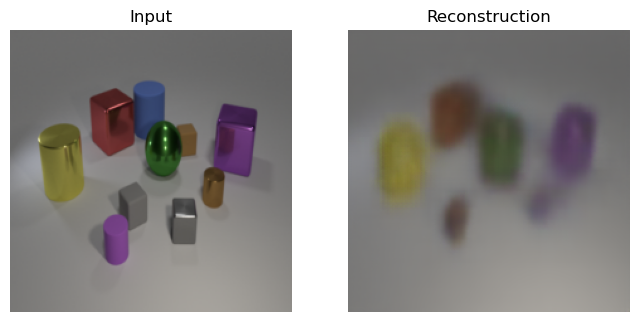

In [8]:
import matplotlib.pyplot as plt

def show_img(t):
    # t: (3,H,W) in [0,1]
    t = t.permute(1,2,0).numpy()
    plt.imshow(t)
    plt.axis("off")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Input")
show_img(image)          # dataset 给的 image 通常已是 [0,1]

plt.subplot(1,2,2)
plt.title("Reconstruction")
show_img(recon)

plt.show()
